<a href="https://colab.research.google.com/github/ZahraDehghani99/Activity_Recognition/blob/master/activity_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Activity Recognition

## EDA

In [ ]:
import pandas as pd
import numpy as np
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn import metrics
import matplotlib.pyplot as plt


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# unzip a folder
# !unzip -q /content/drive/MyDrive/ML_Dr.sajedi/sensors-19-05524-s001.zip -d /content/drive/MyDrive/ML_Dr.sajedi/sensors-19-05524-s001

Let's define a funtion to read label of each column form .txt file.

In [ ]:
def readFile(filename):
  fileObj = open(filename, 'r', encoding='utf-8') # open the file in read mode
  words = fileObj.read().splitlines() # puts the file into an array
  fileObj.close()
  return words

In [ ]:
LABEL_PATH = '/content/drive/MyDrive/ML_Dr.sajedi/sensors-19-05524-s001/sensors-19-05524-s001_new/labels.txt'
column_label = readFile(LABEL_PATH)
print(f'length of column_label : {len(column_label)}')

length of column_label : 535


Attribute Information:

The first column correspond to the index of the subject. The next 174 attributes are statistics extracted from the ECG signal. The next 151 attributes are features extracted from the TEB signal. The next 104 attributes come from the EDA measured in the arm, and the next 104 ones from the EDA in the hand. The last attribute is the pattern class, that is, the corresponding activity: 1-neutral, 2-emotional, 3-mental and 4-physical.


In [ ]:
DATA_PATH = '/content/drive/MyDrive/ML_Dr.sajedi/sensors-19-05524-s001/sensors-19-05524-s001_new/data.txt'
data = pd.read_csv(DATA_PATH, header=None)
data.columns = column_label
data.head()

,Subject index (1-40),ECG_original_mean,ECG_original_std,ECG_original_trimmean25,ECG_original_median,ECG_original_skewness,ECG_original_kurtosis,ECG_original_max,ECG_original_min,ECG_original_prctile25,ECG_original_prctile75,ECG_original_geomean(abs),ECG_original_harmmean,ECG_original_mad,ECG_original_baseline,ECG_RR_window_mean,ECG_RR_window_std,ECG_RR_window_trimmean25,ECG_RR_window_median,ECG_RR_window_skewness,ECG_RR_window_kurtosis,ECG_RR_window_max,ECG_RR_window_min,ECG_RR_window_prctile25,ECG_RR_window_prctile75,ECG_RR_window_geomean(abs),ECG_RR_window_harmmean,ECG_RR_window_mad,ECG_RR_window_baseline,ECG_amplitude_RR_mean,ECG_amplitude_RR_std,ECG_amplitude_RR_trimmean25,ECG_amplitude_RR_median,ECG_amplitude_RR_skewness,ECG_amplitude_RR_kurtosis,ECG_amplitude_RR_max,ECG_amplitude_RR_min,ECG_amplitude_RR_prctile25,ECG_amplitude_RR_prctile75,ECG_amplitude_RR_geomean(abs),...,EDA_Functionals_power_Originalmedian,EDA_Functionals_power_Originalskewness,EDA_Functionals_power_Originalkurtosis,EDA_Functionals_power_Originalmax,EDA_Functionals_power_Originalmin,EDA_Functionals_power_Originalprctile25,EDA_Functionals_power_Originalprctile75,EDA_Functionals_power_Originalgeomean(abs),EDA_Functionals_power_Originalharmmean,EDA_Functionals_power_Originalmad,EDA_Functionals_power_Originalbaseline,EDA_Functionals_power_Fil12mean,EDA_Functionals_power_Fil12std,EDA_Functionals_power_Fil12trimmean25,EDA_Functionals_power_Fil12median,EDA_Functionals_power_Fil12skewness,EDA_Functionals_power_Fil12kurtosis,EDA_Functionals_power_Fil12max,EDA_Functionals_power_Fil12min,EDA_Functionals_power_Fil12prctile25,EDA_Functionals_power_Fil12prctile75,EDA_Functionals_power_Fil12geomean(abs),EDA_Functionals_power_Fil12harmmean,EDA_Functionals_power_Fil12mad,EDA_Functionals_power_Fil12baseline,EDA_Functionals_power_Filt2mean,EDA_Functionals_power_Filt2std,EDA_Functionals_power_Filt2trimmean25,EDA_Functionals_power_Filt2median,EDA_Functionals_power_Filt2skewness,EDA_Functionals_power_Filt2kurtosis,EDA_Functionals_power_Filt2max,EDA_Functionals_power_Filt2min,EDA_Functionals_power_Filt2prctile25,EDA_Functionals_power_Filt2prctile75,EDA_Functionals_power_Filt2geomean(abs),EDA_Functionals_power_Filt2harmmean,EDA_Functionals_power_Filt2mad,EDA_Functionals_power_Filt2baseline,"Activity: 1-neutral, 2-emotional, 3-mental and 4-physical"
0,1,-0.004125,0.254095,0.001426,-0.01037,-0.538509,5.95534,1.04063,-1.37437,-0.10937,0.10763,0.093296,-0.065212,0.172694,0.001901,231.814,16.2733,230.818,231.0,0.374904,2.26279,265,205,218.25,242.75,231.263,230.721,13.4375,246.442,0.715107,0.196952,0.737071,0.74063,-2.421450,11.93200,1.04063,-0.18837,0.67213,0.80463,0.697440,...,9.03663,31.4247,1015.35,1.160930e+09,0.049631,3.68860,26.8278,12.09630,2.47663,2288290.0,4901420.0,1146810.0,33327500.0,14.7410,8.34680,31.4249,1015.36,1.160800e+09,0.018150,3.06333,24.5346,9.69082,1.079070,2288000.0,4902090.0,708396.0,20586600.0,10.43340,5.83548,31.4249,1015.36,717032000.0,0.027384,2.53425,17.3882,8.05589,1.80247,1413310.0,3028080.0,1
1,1,0.031029,0.193761,0.012918,-0.00237,0.781415,5.18794,0.98963,-0.71937,-0.08737,0.11163,0.079461,-0.057924,0.142173,0.002046,230.500,15.5536,229.469,230.0,0.397898,2.37158,265,205,216.00,240.00,229.995,229.497,12.8333,246.362,0.752583,0.091733,0.747993,0.74163,0.471318,3.23181,0.98963,0.58063,0.69563,0.80263,0.747229,...,8.67972,31.4359,1015.80,1.141910e+09,0.018680,3.65946,25.3309,11.62070,2.07160,2248930.0,4882550.0,1127960.0,32813200.0,14.2791,8.09314,31.4354,1015.78,1.142700e+09,0.006967,2.90268,23.7557,8.98575,0.638533,2250550.0,4883220.0,696749.0,20268900.0,10.24230,5.76355,31.4354,1015.78,705854000.0,0.016947,2.51513,16.5914,7.81769,1.52349,1390180.0,3016420.0,1
2,1,0.015678,0.182336,-0.003028,-0.02337,0.881194,5.66530,0.87563,-0.71937,-0.08037,0.08863,0.074408,-0.042190,0.131310,0.002114,240.707,20.8210,239.871,238.0,0.725535,3.99127,309,205,225.25,258.25,239.855,239.027,16.7591,246.334,0.727153,0.071073,0.727380,0.72663,0.021448,2.55858,0.87563,

In [ ]:
print(f'shape of data : {data.shape}')

shape of data : (4480, 535)


Show the statistical attributes of the dataset.

In [ ]:
data.describe()

,Subject index (1-40),ECG_original_mean,ECG_original_std,ECG_original_trimmean25,ECG_original_median,ECG_original_skewness,ECG_original_kurtosis,ECG_original_max,ECG_original_min,ECG_original_prctile25,ECG_original_prctile75,ECG_original_geomean(abs),ECG_original_harmmean,ECG_original_mad,ECG_original_baseline,ECG_RR_window_mean,ECG_RR_window_std,ECG_RR_window_trimmean25,ECG_RR_window_median,ECG_RR_window_skewness,ECG_RR_window_kurtosis,ECG_RR_window_max,ECG_RR_window_min,ECG_RR_window_prctile25,ECG_RR_window_prctile75,ECG_RR_window_geomean(abs),ECG_RR_window_harmmean,ECG_RR_window_mad,ECG_RR_window_baseline,ECG_amplitude_RR_mean,ECG_amplitude_RR_std,ECG_amplitude_RR_trimmean25,ECG_amplitude_RR_median,ECG_amplitude_RR_skewness,ECG_amplitude_RR_kurtosis,ECG_amplitude_RR_max,ECG_amplitude_RR_min,ECG_amplitude_RR_prctile25,ECG_amplitude_RR_prctile75,ECG_amplitude_RR_geomean(abs),...,EDA_Functionals_power_Originalmedian,EDA_Functionals_power_Originalskewness,EDA_Functionals_power_Originalkurtosis,EDA_Functionals_power_Originalmax,EDA_Functionals_power_Originalmin,EDA_Functionals_power_Originalprctile25,EDA_Functionals_power_Originalprctile75,EDA_Functionals_power_Originalgeomean(abs),EDA_Functionals_power_Originalharmmean,EDA_Functionals_power_Originalmad,EDA_Functionals_power_Originalbaseline,EDA_Functionals_power_Fil12mean,EDA_Functionals_power_Fil12std,EDA_Functionals_power_Fil12trimmean25,EDA_Functionals_power_Fil12median,EDA_Functionals_power_Fil12skewness,EDA_Functionals_power_Fil12kurtosis,EDA_Functionals_power_Fil12max,EDA_Functionals_power_Fil12min,EDA_Functionals_power_Fil12prctile25,EDA_Functionals_power_Fil12prctile75,EDA_Functionals_power_Fil12geomean(abs),EDA_Functionals_power_Fil12harmmean,EDA_Functionals_power_Fil12mad,EDA_Functionals_power_Fil12baseline,EDA_Functionals_power_Filt2mean,EDA_Functionals_power_Filt2std,EDA_Functionals_power_Filt2trimmean25,EDA_Functionals_power_Filt2median,EDA_Functionals_power_Filt2skewness,EDA_Functionals_power_Filt2kurtosis,EDA_Functionals_power_Filt2max,EDA_Functionals_power_Filt2min,EDA_Functionals_power_Filt2prctile25,EDA_Functionals_power_Filt2prctile75,EDA_Functionals_power_Filt2geomean(abs),EDA_Functionals_power_Filt2harmmean,EDA_Functionals_power_Filt2mad,EDA_Functionals_power_Filt2baseline,"Activity: 1-neutral, 2-emotional, 3-mental and 4-physical"
count,4480.000000,4480.000000,4480.000000,4480.000000,4480.000000,4480.000000,4480.000000,4480.000000,4480.000000,4480.000000,4480.000000,4480.000000,4480.000000,4480.000000,4480.000000,4480.000000,4480.000000,4480.000000,4480.000000,4480.000000,4480.000000,4480.000000,4480.000000,4480.000000,4480.000000,4480.000000,4480.000000,4480.000000,4480.000000,4480.000000,4480.000000,4480.000000,4480.000000,4480.000000,4480.000000,4480.000000,4480.000000,4480.000000,4480.000000,4480.000000,...,4480.000000,4480.000000,4480.000000,4.480000e+03,4480.000000,4480.000000,4480.000000,4480.000000,4480.000000,4.480000e+03,4.480000e+03,4.480000e+03,4.480000e+03,4480.000000,4480.000000,4480.000000,4480.000000,4.480000e+03,4480.000000,4480.000000,4480.000000,4480.000000,4480.000000,4.480000e+03,4.480000e+03,4.480000e+03,4.480000e+03,4480.000000,4480.000000,4480.000000,4480.000000,4.480000e+03,4480.000000,4480.000000,4480.000000,4480.000000,4480.000000,4.480000e+03,4.480000e+03,4480.000000
mean,20.500000,0.069109,0.488721,0.064519,0.068895,0.640896,6.986733,1.504077,-1.243163,-0.260268,0.377705,0.324323,-0.594561,0.383814,-0.024551,196.950466,26.121304,194.828574,193.462612,0.611869,6.381564,278.637277,156.317857,181.052065,209.359542,193.965991,191.525931,18.948404,216.413810,0.415134,0.459970,0.423519,0.435287,-0.114528,4.677233,1.351817,-0.623824,0.116165,0.724552,0.579713,...,208.481570,30.995357,995.271625,2.886970e+10,0.218751,74.657495,608.083071,230.124258,13.679398,5.687778e+07,2.201300e+07,2.851780e+07,8.291709e+08,359.494011,207.227406,31.008114,995.769821,2.886970e+10,0.145724,73.200346,602.278770,221.623425,9.257172,5.687775e+07,2.201289e

Let's check for NaN in dataframe.

In [ ]:
print(f'we have {data.isnull().sum().sum()} NaN in our dataset.')

we have 0 NaN in our dataset.


let's remove first column, because it's index of the subject.

In [ ]:
data.drop('Subject index (1-40)', axis=1, inplace=True)

print(f'data shape : {data.shape}')

data shape : (4480, 534)


### Split X and y

In [ ]:
# change name of laste column into `label`
data = data.rename(columns={'Activity: 1-neutral, 2-emotional, 3-mental and 4-physical': 'label'})

y = data['label']
X = data.drop('label', axis=1)

print (f'y shape : {y.shape}')
print (f'X shape : {X.shape}')

y shape : (4480,)
X shape : (4480, 533)


As wee seen, we have balanced dataset.

In [ ]:
y.value_counts()

3    1120
2    1120
1    1120
4    1120
Name: label, dtype: int64

In the below, we saw distribution of first 18 features. As we can see, they have gaussian distribution, so it's better to perform standardization on dataset.

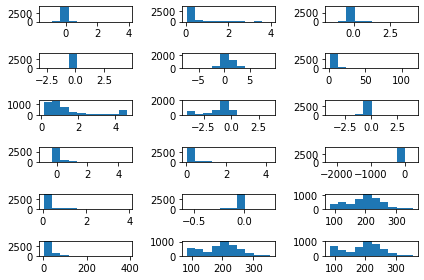

In [ ]:
for idx, i in enumerate(data.columns[:18]):
  plt.subplot(6, 3, idx+1) 
  plt.hist(data[i])
  plt.tight_layout() 
plt.show()

### Split train and test dataset

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (3584, 533)
X_test shape: (896, 533)
y_train shape: (3584,)
y_test shape: (896,)


### Standardization

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

We can see that distribution of our dataset have mean=0 in all features,

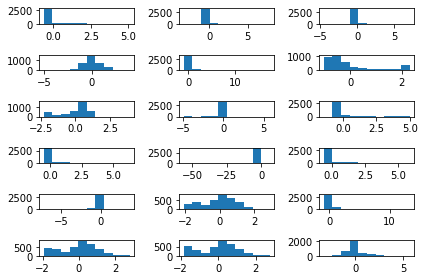

In [ ]:
for i in range(1, 19):
    plt.subplot(6, 3, i)
    plt.hist(X_train[:,i])
    plt.tight_layout()
plt.show()

In [ ]:
X_train

array([[-0.15392825, -0.42490069, -0.17890873, ..., -0.22773846,
        -0.43392092, -0.44116821],
       [-0.1692091 , -0.54966696, -0.168575  , ..., -0.5230204 ,
        -0.50789915, -0.45944318],
       [-0.1687479 , -0.47330904, -0.18214592, ..., -0.22645924,
        -0.43729604, -0.40295913],
       ...,
       [-0.55358893, -0.4368414 , -0.44338296, ..., -0.53078631,
        -0.51379457, -0.46210204],
       [ 0.05596907, -0.33455923,  0.04313537, ..., -0.00228345,
        -0.43415551, -0.44043639],
       [-0.14178845, -0.62701745, -0.13012095, ..., -0.47253073,
        -0.51054695, -0.44718107]])

## Decision Tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import cross_val_score

criterion = ['gini', 'entropy'] # default=”gini”

for criteria in criterion:
  dt = DecisionTreeClassifier(criterion=criteria, random_state=42)
  scores = cross_val_score(dt, X_train, y_train, cv=5)
  print(f'for {criteria} : accuracy {scores.mean()}')


for gini : accuracy 0.8973150074409979
for entropy : accuracy 0.9232739611821448


as we can see entropy is better, becasue it has higher accuraty than gini.

In [ ]:
splitter = ['best', 'random'] # default=”best”

for split in splitter:
  dt = DecisionTreeClassifier(splitter=split, random_state=42)
  scores = cross_val_score(dt, X_train, y_train, cv=5)
  print(f'for {split} : accuracy {scores.mean()}')

for best : accuracy 0.8973150074409979
for random : accuracy 0.917685421098151


random is better than best for splitter.

from depth >=30 the accuracy doesn't change. so we chosse depth=30 because it has simpler complexity.

In [ ]:
max_depth = [4,5,6,7,8,9,10, 20, 30, 40, 50, 60, 100, 150, 200, 300]

for depth in max_depth:
  dt = DecisionTreeClassifier(max_depth=depth, random_state=42)
  scores = cross_val_score(dt, X_train, y_train, cv=5)
  print(f'for depth {depth} : accuracy {scores.mean()}')

for depth 4 : accuracy 0.7229334673492127
for depth 5 : accuracy 0.7538977583506696
for depth 6 : accuracy 0.7784522724262328
for depth 7 : accuracy 0.8108159385396944
for depth 8 : accuracy 0.8339757524757875
for depth 9 : accuracy 0.8557408662724107
for depth 10 : accuracy 0.8741563622480385
for depth 20 : accuracy 0.8967575169662545
for depth 30 : accuracy 0.8973150074409979
for depth 40 : accuracy 0.8973150074409979
for depth 50 : accuracy 0.8973150074409979
for depth 60 : accuracy 0.8973150074409979
for depth 100 : accuracy 0.8973150074409979
for depth 150 : accuracy 0.8973150074409979
for depth 200 : accuracy 0.8973150074409979
for depth 300 : accuracy 0.8973150074409979


Let's train the model on the best parameters.

In [ ]:
dt = DecisionTreeClassifier(criterion = 'entropy', splitter='random', max_depth=30,random_state=42)
dt = dt.fit(X_train,y_train)

y_pred = dt.predict(X_test)

In [ ]:
print(f'10 first elements of y_pred : {y_pred[:10]}')

10 first elements of y_pred : [2 2 1 4 3 4 2 2 3 4]


Let's plot our decision tree classifier.

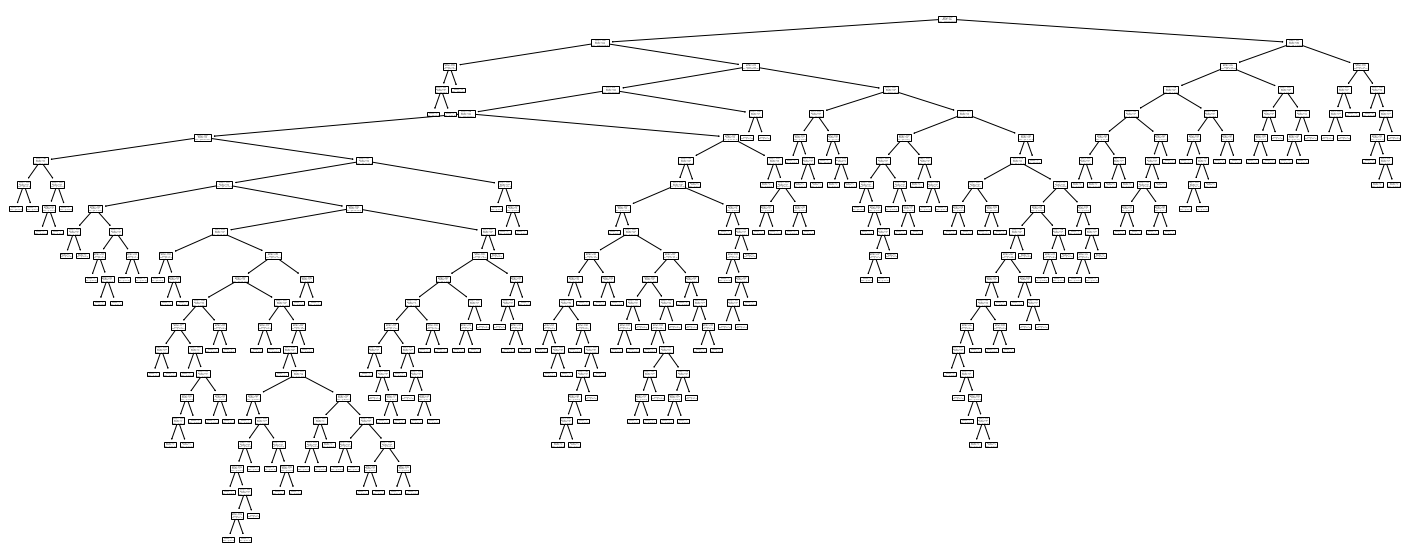

In [ ]:
from sklearn import tree
plt.figure(figsize=(25, 10))
a = tree.plot_tree(dt)
plt.show()

In [ ]:
print(f'decision tree accuracy on train set: {dt.score(X_train, y_train)}')
print(f'decision tree accuracy on test set : {dt.score(X_test, y_test)}')

decistion tree accuracy on train set: 1.0
decistion tree accuracy on test set : 0.9486607142857143


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.98      0.95      0.97       224
           2       0.92      0.93      0.92       226
           3       0.90      0.93      0.92       216
           4       0.99      0.99      0.99       230

    accuracy                           0.95       896
   macro avg       0.95      0.95      0.95       896
weighted avg       0.95      0.95      0.95       896



Let's define a function for plotting confusion matrix.

In [ ]:
import seaborn as sns
def confusion_matrix(y_test, y_pred):
    df_cm = pd.DataFrame(metrics.confusion_matrix(y_test, y_pred), index = [1,2,3,4],
                  columns = [1,2,3,4])
    sns.heatmap(df_cm, annot=True, cmap="YlGnBu" ,fmt='g')
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()  

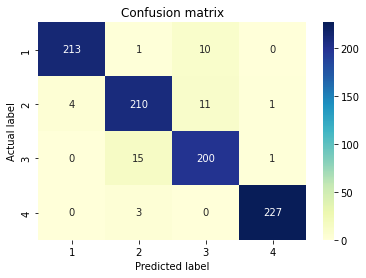

In [ ]:
confusion_matrix(y_test, y_pred)

## Random Forest Classifier

شاید تعجب برانگیر باشد اما اجرای این قطعه کد دو ساعت طول کشید!!!

In [ ]:
criterion = ['gini', 'entropy'] # default=”gini”
max_samples = [0.33, 0.5, 1.0]
n_estimators = [50, 100, 200, 400,600]
max_depth = [5,10,50, 100, 200, 300]

for criteria in criterion:
  for samples in max_samples:
    for estimators in n_estimators:
      for depth in max_depth:

        rf = RandomForestClassifier(criterion=criteria, n_estimators=estimators, max_samples=samples, max_depth=depth, random_state=42)
        scores = cross_val_score(rf, X_train, y_train, cv=5)
        print(f'criteria :{criteria}| max_samples : {samples}| N_estimators: {estimators}| depth: {depth} => accuracy {scores.mean()}')

criteria :gini| max_samples : 0.33| N_estimators: 50| depth: 5 => accuracy 0.8094263029538036
criteria :gini| max_samples : 0.33| N_estimators: 50| depth: 10 => accuracy 0.9135005415176518
criteria :gini| max_samples : 0.33| N_estimators: 50| depth: 50 => accuracy 0.9380546660121706
criteria :gini| max_samples : 0.33| N_estimators: 50| depth: 100 => accuracy 0.9380546660121706
criteria :gini| max_samples : 0.33| N_estimators: 50| depth: 200 => accuracy 0.9380546660121706
criteria :gini| max_samples : 0.33| N_estimators: 50| depth: 300 => accuracy 0.9380546660121706
criteria :gini| max_samples : 0.33| N_estimators: 100| depth: 5 => accuracy 0.8102611751322627
criteria :gini| max_samples : 0.33| N_estimators: 100| depth: 10 => accuracy 0.9171279306234077
criteria :gini| max_samples : 0.33| N_estimators: 100| depth: 50 => accuracy 0.9441913466258386
criteria :gini| max_samples : 0.33| N_estimators: 100| depth: 100 => accuracy 0.9441913466258386
criteria :gini| max_samples : 0.33| N_estima

In [ ]:
rf = RandomForestClassifier(criterion = 'entropy', n_estimators=400, max_depth=50,max_samples =1.0, random_state=42)
rf = rf.fit(X_train,y_train)

y_pred = rf.predict(X_test)

In [ ]:
print(f'10 first elements of y_pred : {y_pred[:10]}')

10 first elements of y_pred : [2 2 1 4 3 4 2 2 3 4]


In [ ]:
print(f'random forest accuracy on train set: {rf.score(X_train, y_train)}')
print(f'random forest accuracy on test set : {rf.score(X_test, y_test)}')

random forest accuracy on train set: 1.0
random forest accuracy on test set : 0.9899553571428571


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       1.00      0.98      0.99       224
           2       0.97      1.00      0.99       226
           3       0.99      0.98      0.98       216
           4       1.00      1.00      1.00       230

    accuracy                           0.99       896
   macro avg       0.99      0.99      0.99       896
weighted avg       0.99      0.99      0.99       896



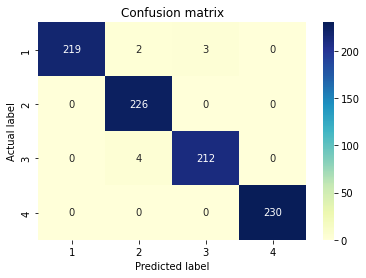

In [ ]:
confusion_matrix(y_test, y_pred)

## XGBoost Classfier

In [ ]:
from xgboost import XGBClassifier

max_depth = [5, 10, 50]

for depth in max_depth:
        
    xgb = XGBClassifier(objective='multi:sofmax', max_depth=depth, num_classes=4, random_state=42)
    scores = cross_val_score(xgb, X_train, y_train, cv=5)
    print(f'depth: {depth}  => accuracy {scores.mean()}')


depth: 5  => accuracy 0.986607372431687
depth: 10  => accuracy 0.9868855332974918
depth: 50  => accuracy 0.9838168034096133


As we seen, depth=10 is better than other depths.

In [ ]:
n_estimators = [300, 500]

for estimator in n_estimators:
      
    xgb = XGBClassifier(objective='multi:sofmax', max_depth=10, n_estimators=estimator,num_classes=4, random_state=42)
    scores = cross_val_score(xgb, X_train, y_train, cv=5)
    print(f'N_estimators: {estimator} => accuracy {scores.mean()}')

N_estimators: 300 => accuracy 0.9905129224032476
N_estimators: 500 => accuracy 0.9913497424869296


As we can see, n_estimator=500 is better than other .

In [ ]:
learning_rate = [0.1, 0.01, 0.001]

for lr in learning_rate:
        
    xgb = XGBClassifier(objective='multi:sofmax', max_depth=10, n_estimators=500, learning_rate=lr, num_classes=4, random_state=42)
    scores = cross_val_score(xgb, X_train, y_train, cv=5)
    print(f'lr : {lr} => accuracy {scores.mean()}')

lr : 0.1 => accuracy 0.9913497424869296
lr : 0.01 => accuracy 0.9779578940807057
lr : 0.001 => accuracy 0.9450297250336988


In [ ]:
xgb = XGBClassifier(objective='multi:sofmax', max_depth=10, n_estimator=500, learning_rate=0.1, num_classes=4, random_state=42)
xgb = xgb.fit(X_train,y_train)

y_pred = xgb.predict(X_test)

In [ ]:
print(f'10 first elements of y_pred : {y_pred[:10]}')

10 first elements of y_pred : [2 2 1 4 3 4 2 2 3 4]


In [ ]:
print(f'xgb accuracy on train set: {xgb.score(X_train, y_train)}')
print(f'xgb accuracy on test set : {xgb.score(X_test, y_test)}')

random forest accuracy on train set: 1.0
random forest accuracy on test set : 0.9866071428571429


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       1.00      0.97      0.98       224
           2       1.00      0.99      0.99       226
           3       0.96      0.99      0.97       216
           4       0.99      1.00      0.99       230

    accuracy                           0.99       896
   macro avg       0.99      0.99      0.99       896
weighted avg       0.99      0.99      0.99       896



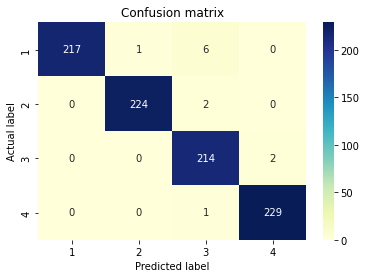

In [ ]:
confusion_matrix(y_test, y_pred)

## SVM Classifier

In [ ]:
kernel = ['linear', 'rbf', 'sigmoid', 'poly']

for kernel in kernel:
        
    svc = svm.SVC(kernel=kernel, random_state=42)
    scores = cross_val_score(svc, X_train, y_train, cv=5)
    print(f'kernel : {kernel} => accuracy {scores.mean()}')

kernel : linear => accuracy 0.8691428437857928
kernel : rbf => accuracy 0.8253348449077862
kernel : sigmoid => accuracy 0.7318622753091326
kernel : poly => accuracy 0.6545721231387767


In [ ]:
decision_function_shape = ['ovo', 'ovr']  #default=’ovr

for function in decision_function_shape:
        
    svc = svm.SVC(kernel='linear', decision_function_shape=function, random_state=42)
    scores = cross_val_score(svc, X_train, y_train, cv=5)
    print(f'decision function shape : {function} => accuracy {scores.mean()}')

decision function shape : ovo => accuracy 0.8691428437857928
decision function shape : ovr => accuracy 0.8691428437857928


In [ ]:
svc = svm.SVC(kernel='linear', decision_function_shape='ovr', random_state=42)
svc = svc.fit(X_train,y_train)

y_pred = svc.predict(X_test)

In [ ]:
print(f'10 first elements of y_pred : {y_pred[:10]}')

10 first elements of y_pred : [2 3 3 4 2 4 2 2 3 4]


In [ ]:
print(f'svm accuracy on train set: {svc.score(X_train, y_train)}')
print(f'svm accuracy on test set : {svc.score(X_test, y_test)}')

random forest accuracy on train set: 0.9174107142857143
random forest accuracy on test set : 0.875


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.93      0.95      0.94       224
           2       0.81      0.82      0.81       226
           3       0.76      0.74      0.75       216
           4       1.00      0.98      0.99       230

    accuracy                           0.88       896
   macro avg       0.87      0.87      0.87       896
weighted avg       0.87      0.88      0.87       896



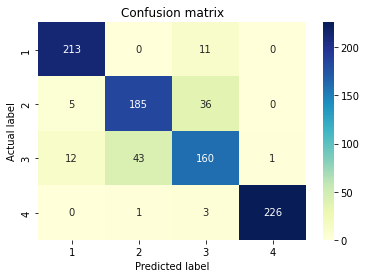

In [ ]:
confusion_matrix(y_test, y_pred)